# Contents

* [<font size=4>Abstract</font>](#1)

* [<font size=4>Objective</font>](#1)

* [<font size=4>The dataset</font>](#1)

* [<font size=4>Performance Metric</font>](#1)


* [<font size=4>EDA</font>](#2)
    * [Preparing the ground](#2.1)
    * [Sales data](#2.2)
    * [Denoising (Wavelet Denoising](#2.3)
    * [Stores and state level](#2.4)

    
* [<font size=4>Modeling</font>](#3)
    * [Train/Val split](#3.1)
    * [Naive approach](#3.2)
    * [Moving average](#3.3)
    * [Holt linear](#3.4)
    * [Exponential smoothing](#3.5)
    * [ARIMA](#3.6)
    * [Prophet](#3.7)
    * [Loss for each model](#3.8)


* [<font size=4>Takeaways</font>](#4)


* [<font size=4>Ending Note</font>](#5)



# Abstract

Walmart, Whole Foods, Amazon, and other large department stores maintain millions of products and record millions of transactions every day. In order to optimize the profit, store manager must keep balance between inventory, current demand, and they are relying on accurate sales prediction to make informed decisions. Most of the existing sales predictions depends on statistical inference from trends. previous forecasting methods requires a lot of extra information from customers to product detailed information and requires customer and product attribute analysis. In this project we will try to build simplified model to predict the unit sales based historical sales record. Our data is from Kaggle M5 Competition, we will use combination of statistical a machine learning including Deep Neural Networks to solve this exciting case study.


# Objective

The objective of the project is to precisely forecast the unit sales for Walmart USA. Incorrect or misleading forecasts on product sales could trigger opportunity and revenue loss for Walmart. For instance, if analyst team failed to estimate the demand for different product for different categories at different stores located in various states during long weekends or thanksgivings, they may lose opportunity to attract thousands of customers and potentially lose millions of dollars of revenue.  We will build a model that will assist the business analyst and manager to improve planning the inventory distribution, inventory storage solutions, promotions and offer decisions.


# The Dataset Information

The dataset consists of five .csv files.

1. calendar.csv - Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913].

3. submission.csv - Demonstrates the correct format for submission to the competition.

4. sell_prices.csv - Contains information about the price of the products sold per store and date.

5. sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales for [d_1 - d_1941].

* In this competition, we need to forecast the sales for [d_1942 - d_1969]. These rows form the evaluation set. The rows [d_1914 - d_1941] form the validation set, and the remaining rows form the training set. Now, since we understand the dataset and know what to predict, let us visualize the dataset.

* Dataset was provided by Walmart USA, involves unit sales of various product sold in the USA, organized in the form of grouped time series.
*	Dataset contains unique 3049 products, classified in 3 product categories (Hobbies, Food, and Household), and 7 product departments, products are sold across 10 stores in 3 different states (CA, TX, WI )
*	In this respect, the bottom-level of the hierarchy, i.e., product-store unit sales can be mapped across either product categories or geographical regions, as follows:
* Every product has selling history of 1941 days, (test data of h=28 days not included)





![Imgur](https://i.imgur.com/WB6hm1l.png)

# Perfromance Metric

The accuracy of the point forecasts will be evaluated using the R**oot Mean Squared Scaled Error (RMSSE)**, The measure is calculated for each series as follows.

> $RMSSE =\sqrt{\frac{1}{h} * \frac{\sum_{t=n+1}^{t=n+h} {(Y_t - \hat{Y_t}})^2}{\frac{1}{n-1}*(\sum_{t=2}^{t=n}(y_t-y_{t-1)})^2}}$

where Yt  is the actual future value of the examined time series at point t,  the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon. After estimating RMSSE for all the time series of the competition, participant method will be ranked using** Weighted RMSSE**.

> $WRMSSE =\sum_{i=1}^{i=42840} {w_i * RMSSE}$


where W_i is the weight of the ith series of the competition?  n is the total number of time series in competition, A lower WRMSSE score is better. *weight of each series will be computed based on the last 28 observations of the training sample of the dataset*, i.e., **the cumulative actual dollar sales that each series displayed in that period (sum of units sold multiplied by their respective price**).


### Import Library

In [1]:

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import os
import gc
import time
import math
import datetime

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

### Load the data

In [2]:
calendar_df = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
sells_price_df = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
sales_train_validation_df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
sales_train_evalution_df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')
submission_df = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')



In [3]:
# CSS color: for plotly graphics

#                 aliceblue, antiquewhite, aqua, aquamarine, azure,
#                 beige, bisque, black, blanchedalmond, blue,
#                 blueviolet, brown, burlywood, cadetblue,
#                 chartreuse, chocolate, coral, cornflowerblue,
#                 cornsilk, crimson, cyan, darkblue, darkcyan,
#                 darkgoldenrod, darkgray, darkgrey, darkgreen,
#                 darkkhaki, darkmagenta, darkolivegreen, darkorange,
#                 darkorchid, darkred, darksalmon, darkseagreen,
#                 darkslateblue, darkslategray, darkslategrey,
#                 darkturquoise, darkviolet, deeppink, deepskyblue,
#                 dimgray, dimgrey, dodgerblue, firebrick,
#                 floralwhite, forestgreen, fuchsia, gainsboro,
#                 ghostwhite, gold, goldenrod, gray, grey, green,
#                 greenyellow, honeydew, hotpink, indianred, indigo,
#                 ivory, khaki, lavender, lavenderblush, lawngreen,
#                 lemonchiffon, lightblue, lightcoral, lightcyan,
#                 lightgoldenrodyellow, lightgray, lightgrey,
#                 lightgreen, lightpink, lightsalmon, lightseagreen,
#                 lightskyblue, lightslategray, lightslategrey,
#                 lightsteelblue, lightyellow, lime, limegreen,
#                 linen, magenta, maroon, mediumaquamarine,
#                 mediumblue, mediumorchid, mediumpurple,
#                 mediumseagreen, mediumslateblue, mediumspringgreen,
#                 mediumturquoise, mediumvioletred, midnightblue,
#                 mintcream, mistyrose, moccasin, navajowhite, navy,
#                 oldlace, olive, olivedrab, orange, orangered,
#                 orchid, palegoldenrod, palegreen, paleturquoise,
#                 palevioletred, papayawhip, peachpuff, peru, pink,
#                 plum, powderblue, purple, red, rosybrown,
#                 royalblue, saddlebrown, salmon, sandybrown,
#                 seagreen, seashell, sienna, silver, skyblue,
#                 slateblue, slategray, slategrey, snow, springgreen,
#                 steelblue, tan, teal, thistle, tomato, turquoise,
#                 violet, wheat, white, whitesmoke, yellow,
#                 yellowgreen

## Sales Data

### Plotting Sampel Sales Data

In [4]:
sales_train_validation_df[10000:10005]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
10000,HOUSEHOLD_1_295_CA_4_validation,HOUSEHOLD_1_295,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10001,HOUSEHOLD_1_296_CA_4_validation,HOUSEHOLD_1_296,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
10002,HOUSEHOLD_1_297_CA_4_validation,HOUSEHOLD_1_297,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003,HOUSEHOLD_1_298_CA_4_validation,HOUSEHOLD_1_298,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
10004,HOUSEHOLD_1_299_CA_4_validation,HOUSEHOLD_1_299,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,0,1,0,0,1,1,0,1,1


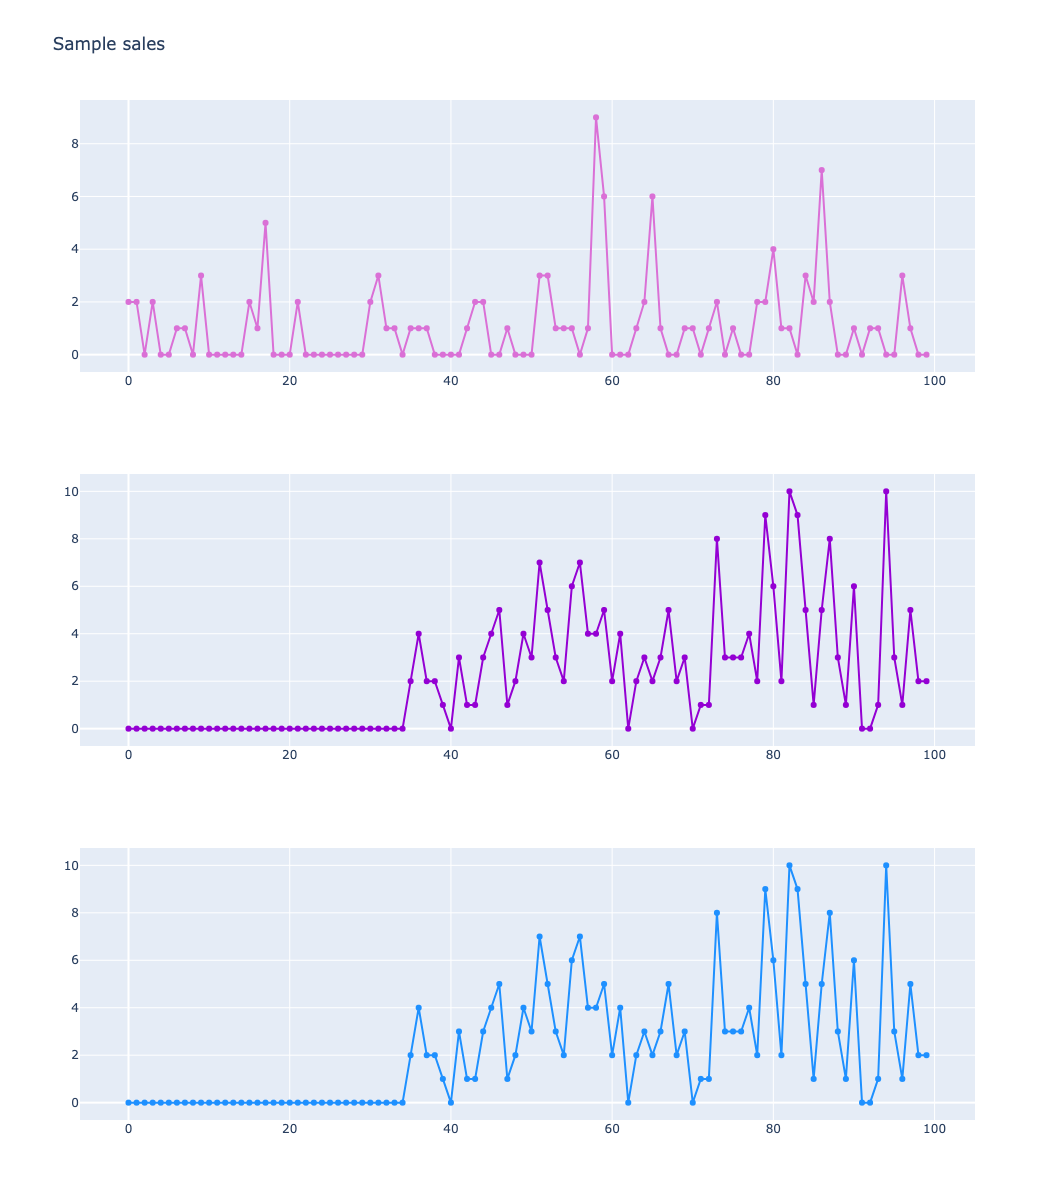

In [5]:
data_colums = [ col for col in sales_train_validation_df if 'd_' in col]
data1 = sales_train_validation_df.loc[sales_train_validation_df['id'] == 'HOBBIES_1_005_CA_1_validation'].set_index('id')[data_colums].values[0][1300:1400]
data2 = sales_train_validation_df.loc[sales_train_validation_df['id'] == 'FOODS_3_800_WI_3_validation'].set_index('id')[data_colums].values[0][1300:1400]
data3 = sales_train_validation_df.loc[sales_train_validation_df['id'] == 'HOUSEHOLD_2_200_CA_4_validation'].set_index('id')[data_colums].values[0][1300:1400]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(data1)), y=data1, showlegend=False,
                    mode='lines+markers', name="HOBBIES_1_005_CA_1",
                         marker=dict(color="orchid")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(data2)), y=data2, showlegend=False,
                    mode='lines+markers', name="FOODS_3_800_WI_3",
                         marker=dict(color="darkviolet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(data2)), y=data2, showlegend=False,
                    mode='lines+markers', name="HOUSEHOLD_2_200_CA_4",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

### Observation:

* This is sales data ploted for randomly selected item. We can clearly see that sales unit is very erratic.
* For last 2 plot,  **sales data is 0** for first few days, which means that **certain products are not available**  for certain days or even weeks. 
* If we zoom in to sample dataset we can see that **sales are zero for few days**, and the other item, it **remains same for few days**, and some times it goes up and down.  There are lots of noise in sales data, we could not see clear pattern without processing data.
* We need some sort of **"denoising"** techniques to **find underlying trends** in sales data before we can accurately forecast.



## Denoising

### Wavelet denoising
Wavelet denoising (usually used with electric signals) is a way to remove the unnecessary noise from a time series.
wavelets localize features in data to different scales, we can preserve important signal or image features while removing noise.

The basic idea behind wavelet denoising, or wavelet thresholding, is that the wavelet transform concentrates signal and image features in a few large-magnitude wavelet coefficients. Wavelet coefficients which are small in value are typically noise and you can "shrink" those coefficients or remove them without affecting the signal or image quality. After you threshold the coefficients, you reconstruct the data using the inverse wavelet transform.

you can further read about it : [MathWorks Wavelet Transform](https://www.mathworks.com/help/wavelet/ug/wavelet-denoising.html)


### How to define threshold for wavelet coeeficients


MAD (mean absolute deviation) value will be useful to  understand the randomness in the sales, which will help us to define threshold for wavelet coefficients, we will remove the low coefficients from wavelets and reconstruct the sales data signals using inverse wavelet transform, and that's it; we have successfully removed noise from the sales data.


In [6]:
# https://pywavelets.readthedocs.io/en/latest/ref/idwt-inverse-discrete-wavelet-transform.html

def denoise_signal_wavelet(signal, wavelet_form='db4', level=1):
    # wavelet decomposition of signal
    wavelet_coeff = pywt.wavedec(signal, wavelet_form, mode='per')
    mean_abs_dev = np.mean(np.absolute(signal - np.mean(wavelet_coeff[-level], axis=None)), axis=None)
    sigma = (1/0.6745) * mean_abs_dev
    upper_threshold = sigma * np.sqrt(2*np.log(len(signal)))
    wavelet_coeff[1:] = (pywt.threshold(i, value=upper_threshold, mode='hard') for i in wavelet_coeff[1:])
    return pywt.waverec(wavelet_coeff, wavelet_form, mode='per')
    
    


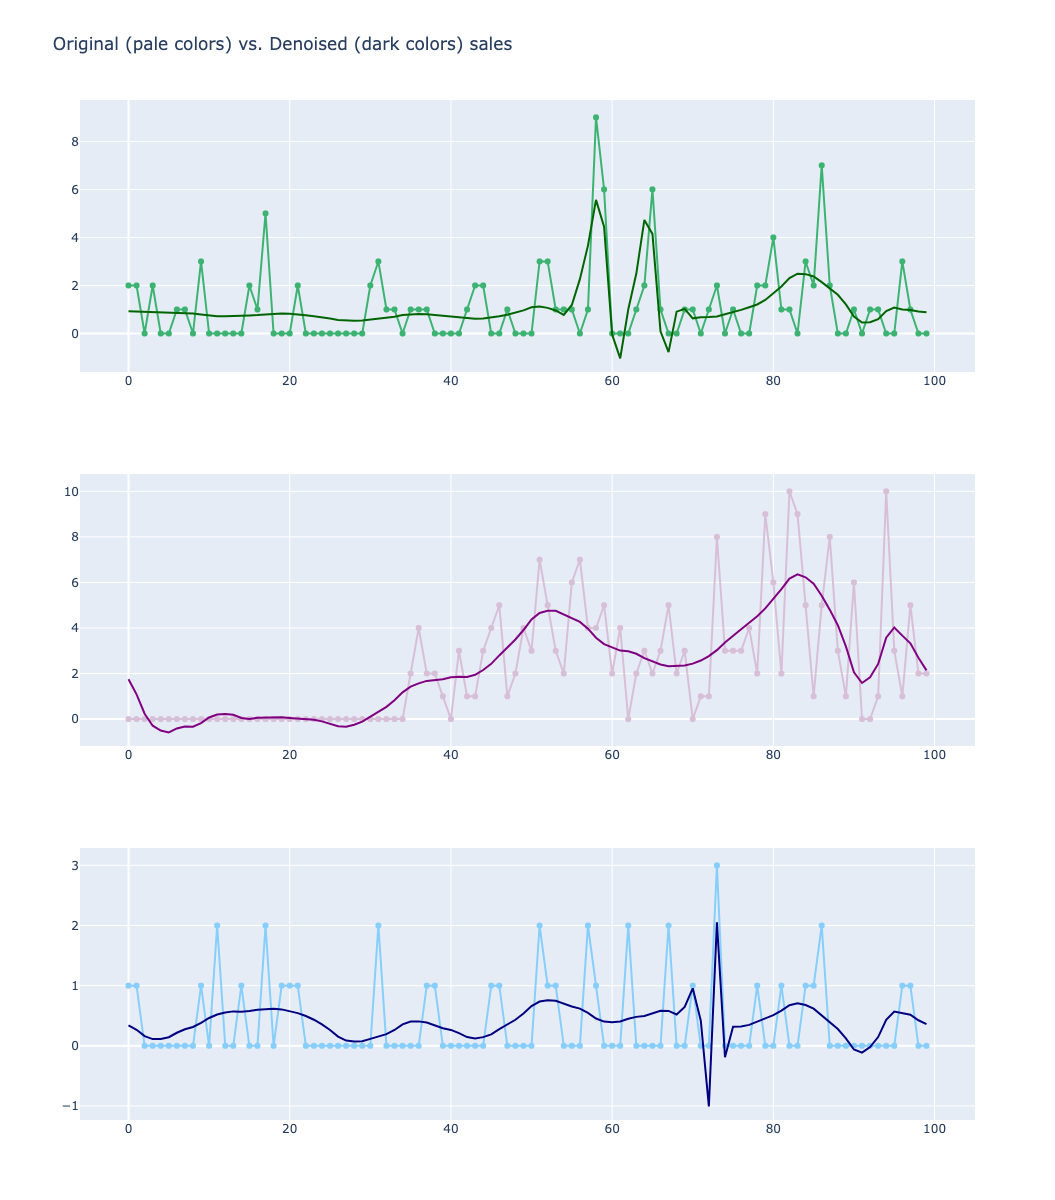

In [7]:
data2_w2 = denoise_signal_wavelet(data2)
data1_w1 = denoise_signal_wavelet(data1)
data3_w3 = denoise_signal_wavelet(data3)

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(data1)), mode='lines+markers', y=data1, marker=dict(color="mediumseagreen"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data1)), y=data1_w1, mode='lines', marker=dict(color="darkgreen"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data2)), mode='lines+markers', y=data2, marker=dict(color="thistle"), showlegend=False,
              name="Original signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data2)), y=data2_w2, mode='lines', marker=dict(color="purple"), showlegend=False,
              name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data3)), mode='markers+lines', y=data3, marker=dict(color="lightskyblue"), showlegend=False, name="Original signal"),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data3)), y=data3_w3, mode='lines', marker=dict(color="navy"), showlegend=False,
              name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale colors) vs. Denoised (dark colors) sales")
fig.show()

### Observation:

* In the above graph I used light lineplots to represent original noisy signal, but I used dark lineplots to represent denoised data using wavelet decomposition and reconstruction. 

* We can see that wavelet denoising is successful in finding "general trend" in sales data without affected by noise present in signals, finding high trends and variation is useful in forecasting.

* Let's seperate out noisy and denoisy signal, plot them seperately.





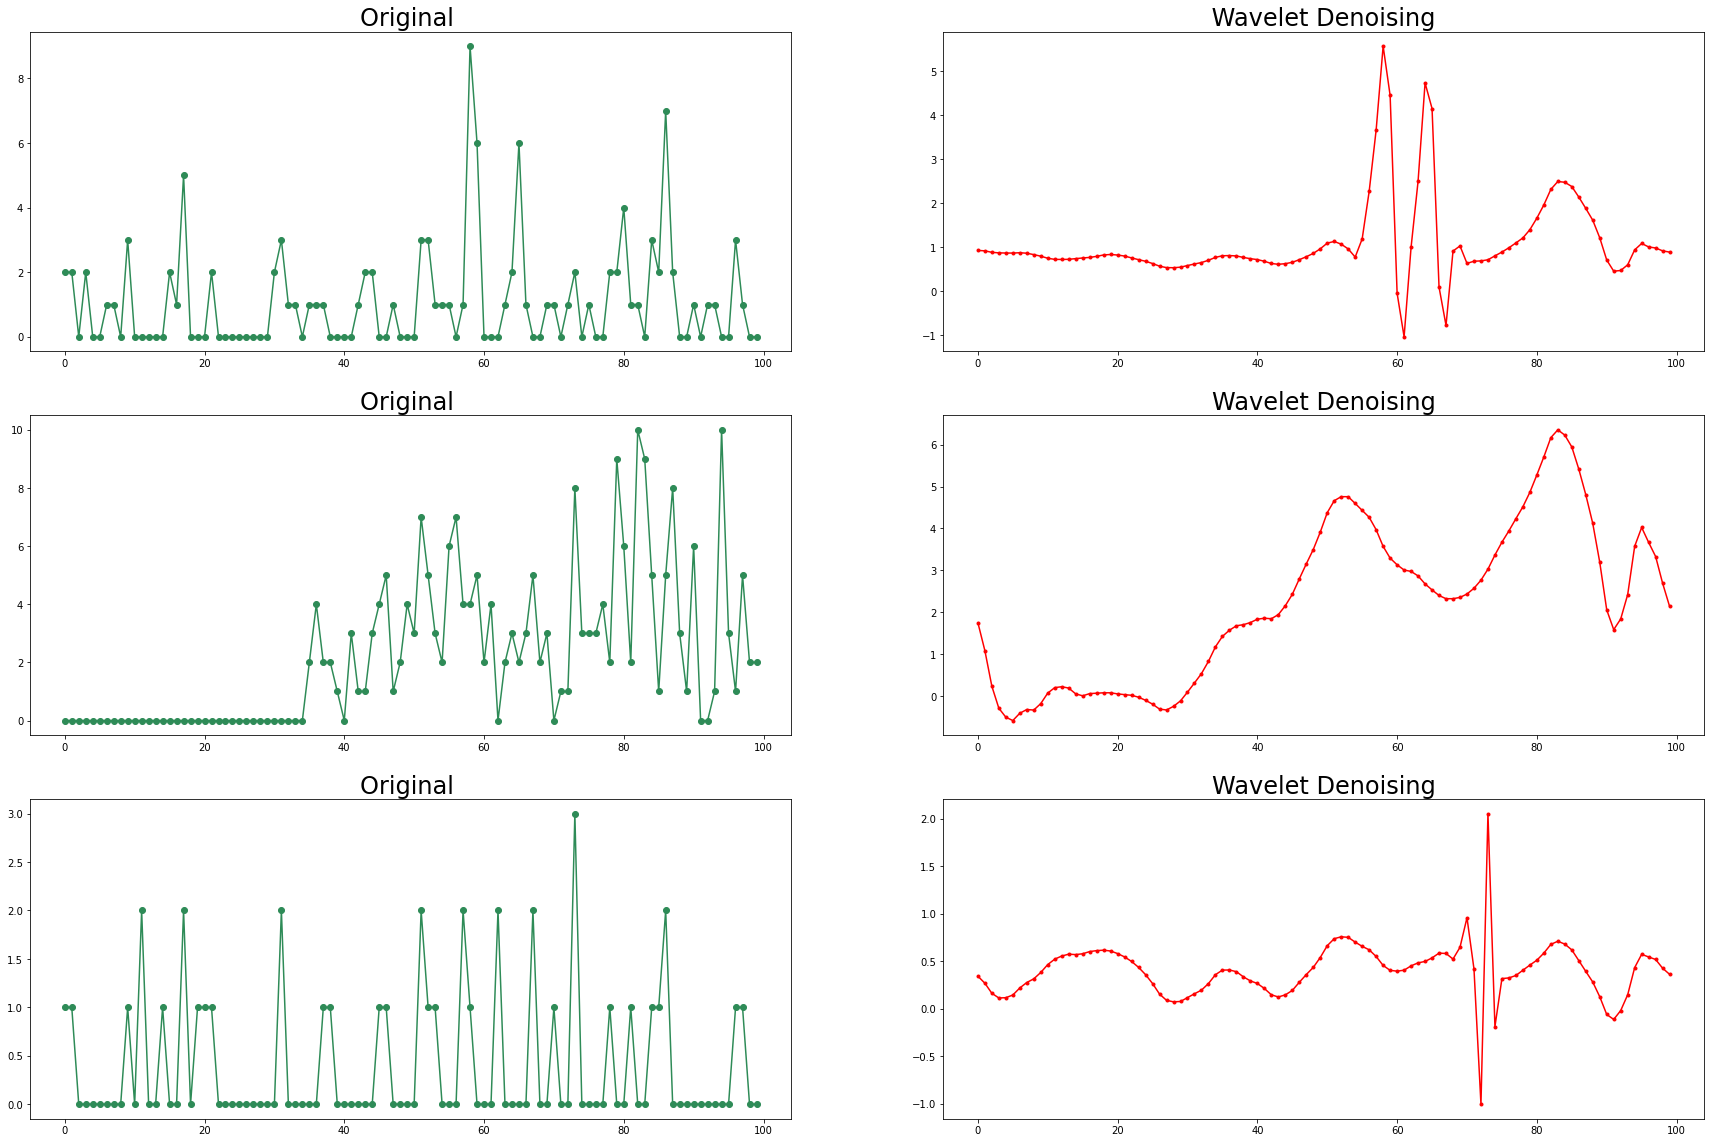

In [8]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

axes[0, 0].plot(data1, color='seagreen', marker='o') 
axes[0, 0].set_title('Original ', fontsize=24)
axes[0, 1].plot(data1_w1, color='red', marker='.') 
axes[0, 1].set_title(' Wavelet Denoising ', fontsize=24)

axes[1, 0].plot(data2, color='seagreen', marker='o') 
axes[1, 0].set_title('Original ', fontsize=24)
axes[1, 1].plot(data2_w2, color='red', marker='.') 
axes[1, 1].set_title('Wavelet Denoising', fontsize=24)

axes[2, 0].plot(data3, color='seagreen', marker='o') 
axes[2, 0].set_title('Original ', fontsize=24)
axes[2, 1].plot(data3_w3, color='red', marker='.') 
axes[2, 1].set_title('Wavelet Denoising', fontsize=24)

plt.show()

## Average smoothing

* Average smooting is a relatively simple way to denoise time series data. 
    
* In this method, we take a "window" with a fixed size (like 5). We first place the window at the beginning of the time series (first five elements) and calculate the mean of that section.
    
* We now slide the window across the time series in the forward direction by a particular "stride", calculate the mean of the new window and repeat the process, until we reach the end of the time series. 
    
* All the mean values we calculated are then concatenated into a new time series, which forms the denoised sales data.

In [9]:

def average_smoothing(signal, kernel_size=3, stride=1):
    sample = [0]*(kernel_size-stride)
    left = 0
    right = kernel_size
    while right <= len(signal):
        left +=  stride
        right += stride
        sample.extend([np.mean(signal[left:right])])
    return np.array(sample)

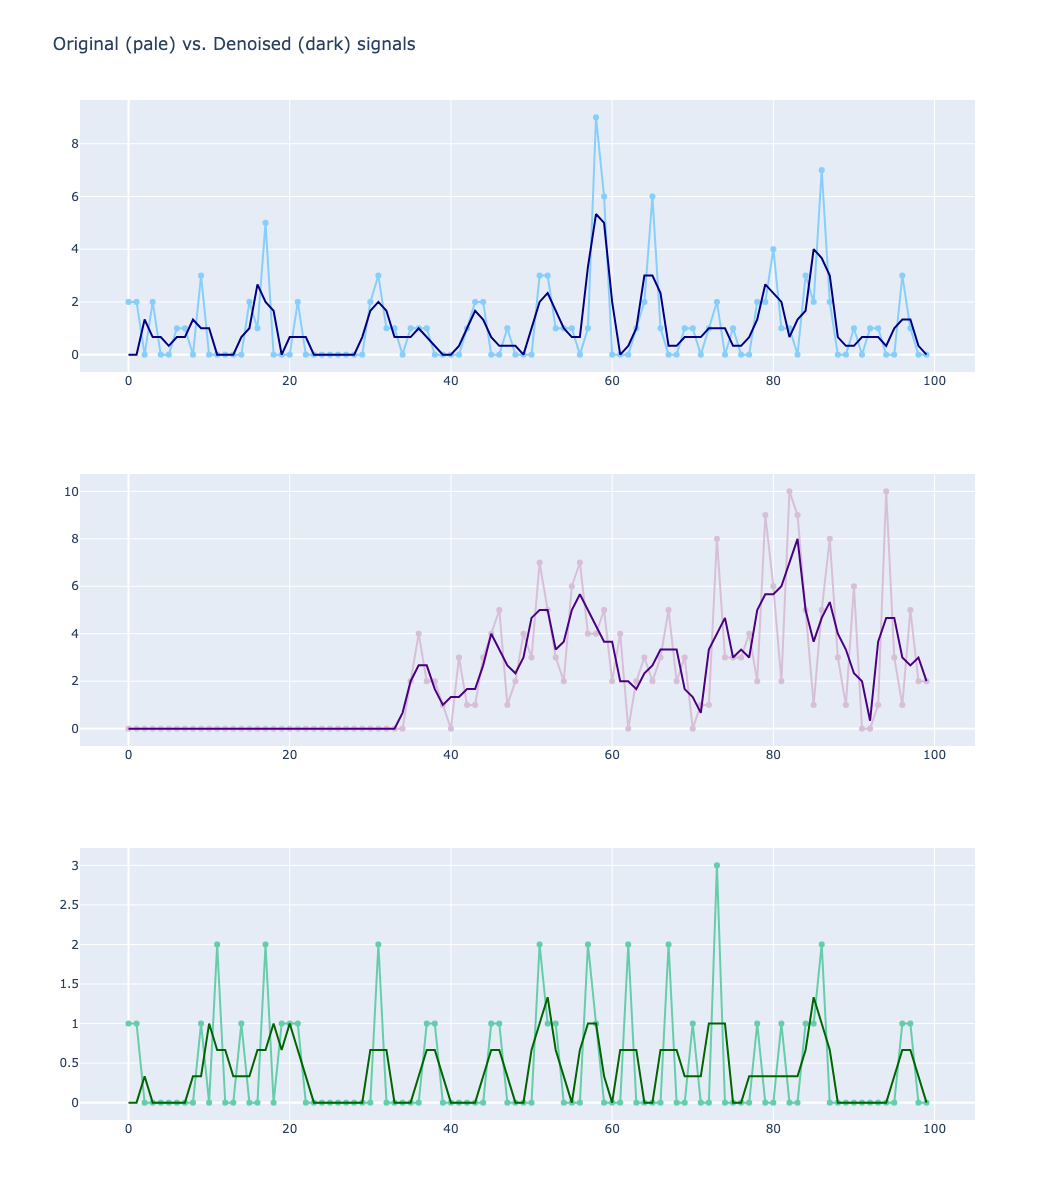

In [10]:
data1_a1 = average_smoothing(data1)
data2_a2 = average_smoothing(data2)
data3_a3 = average_smoothing(data3)

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(data1)), mode='lines+markers', y=data1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data1)), y=data1_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data2)), mode='lines+markers', y=data2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data2)), y=data2_a2, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data3)), mode='lines+markers', y=data3, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(data3)), y=data3_a3, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=3, col=1
)



fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

## Analysis on Store and State Level

In [11]:
# merging sales_train_data and calender data 
sales_history = sales_train_validation_df.set_index('id')[data_colums] \
    .T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [12]:
# California has 4 stores, Texas has 3 and Wisconsin has 3 store in our dataset
storeList= sells_price_df.store_id.unique()
storeList

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

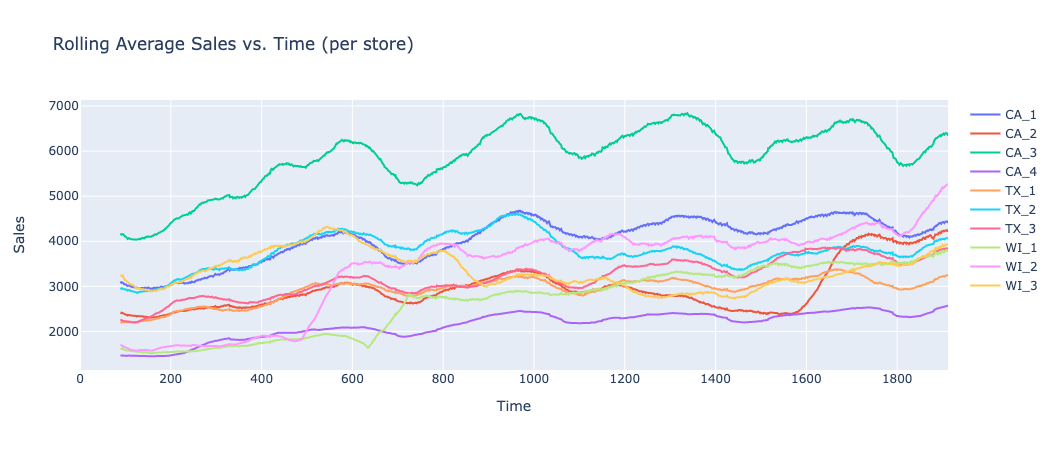

In [13]:
# sales_history
store_means = []
fig = go.Figure()
for store in storeList:
    store_items = [col for col in sales_history.columns if store in col]
    data = sales_history[store_items].sum(axis=1).rolling(90).mean()
    store_means.append(np.mean(sales_history[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=store))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)")

## Observation:

* In the above graph, I have plotted rolling sales ( in window of 90)  across all stores in the dataset. Almost every sales curve has **"linear oscillation"** trend.

* Basically,  this mean value has an **upward linear trend**. From this we can infer that sales are oscillating at higher frequency every few interval.



In [14]:
print(storeList)

['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


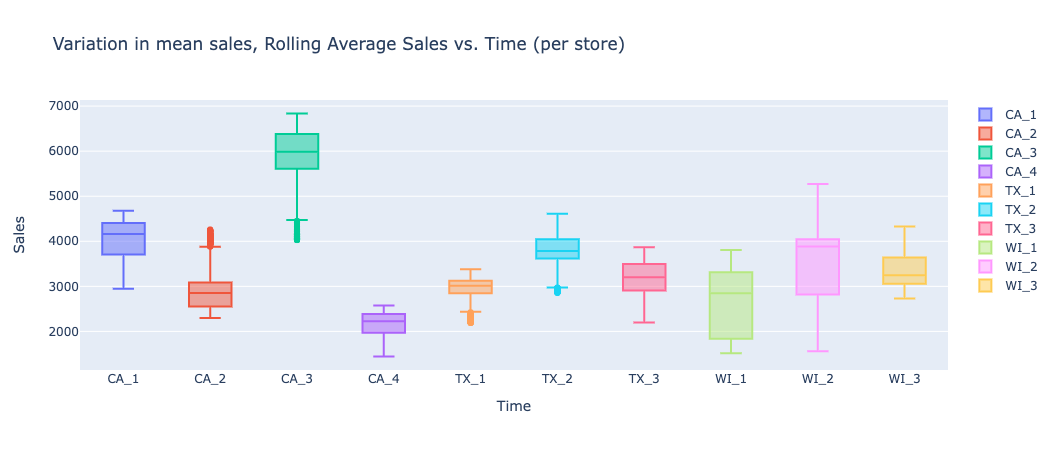

In [19]:
means = []
fig = go.Figure()
for store in storeList:
    store_items = [col for col in sales_history.columns if store in col]
    data = sales_history[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(sales_history[store_items].sum(axis=1)))
    fig.add_trace(go.Box(x=[store]*len(data), y=data, name=store))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Variation in mean sales, Rolling Average Sales vs. Time (per store)")

iplot(fig)

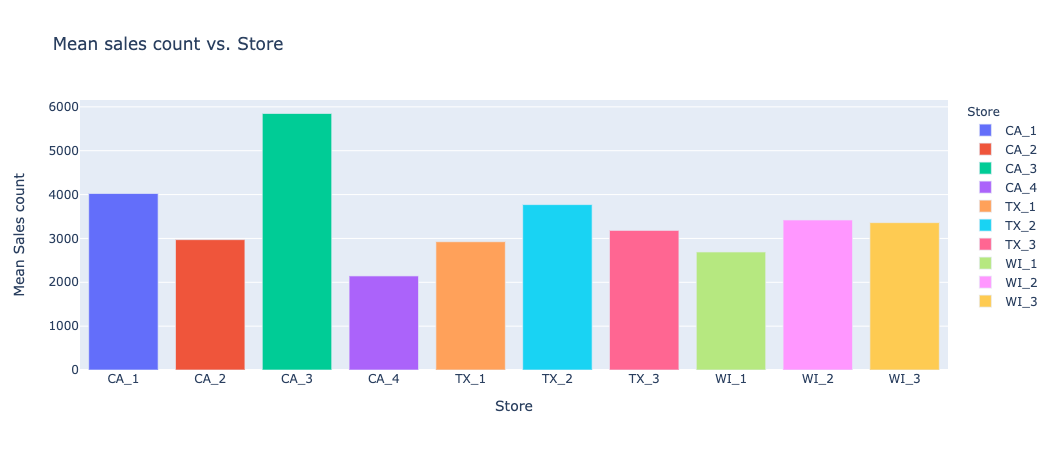

In [16]:
# Plotting mean sales per store

# transpose so that for each row we have storename, store count values
df = pd.DataFrame(np.transpose([store_means, storeList]))
df.head()
df.columns = ["Mean Sales count", "Store"]
px.bar(df, y="Mean Sales count", x="Store", color="Store", title="Mean sales count vs. Store ")

### Observation:

* we plotted sales distribution for each store (total 10 store, 4 in CA, 3 in TX, 3 in WI). 
* **California stores have highest variation**, which indicate that some location california has higher growth rate than others.
* Store in Texas and wisconsin seems overall consistent among them. 
* **California** stores have overall **higher sales mean value**. May be demographics is very important.




In [17]:
# 2011-01-29 to 2016-06-19

In [18]:
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
